In [2]:
import kwant
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse.linalg as sla
import numpy as np
import tinyarray
import matplotlib.cm as cm

In [3]:
# Constants:
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

In [4]:
def on_site(a, mu, Vx):
    """Onsite Hamiltonian element"""
    return ((1/a**2 - mu) * sigma_0 + Vx * sigma_x)

In [5]:
def hop_horz(a):
    """"Horizontal hopping Hamiltonian element"""
    return ((1j * sigma_y)/(2*a) - sigma_0/(2 * a**2))

In [6]:
def hop_vert(a):
    """"Vertical hopping Hamiltonian element"""
    return (-1j * sigma_x/(2 * a) - sigma_0/(2 * a**2))

In [7]:
def theta(x):
    """"Theta function: returns 1 for x >=0, and 0 for x < 0"""
    if x >=1:
        return (1)
    else:
        return (0)

In [8]:
def supercond(delta, a, i, L, phase):
    left_supercond = delta * theta(a* i - L) * sigma_0
    right_supercond = delta *  theta(-a * i + L) * (np.cos(phase) - 1j * np.sin(phase)) * sigma_0
    return(left_supercond + right_supercond)
    

In [9]:
#supercond(1., 2, 1, 20, 0)

In [10]:
def create_sys(a = 2, W = 20, L = 20, mu = 1.0, delta = 1.0, \
               mu_lead = 1.0, attach_leads = True, Vx = 0., phase = 0):
    """Construct a tight-binding model of a Josephson Junction.

    Parameters:
    -----------
    a : natural. 
        Lattice constant
    W : natural. 
        Width of system in lattic points
    L : natural. 
        Lenth of system in lattic points
    mu : real. 
        Chemical potential
    delta : real. 
        Superconducting gap
    mu_lead: real.
        Chemical potential in lead
    attach_leads: boolean.
        Attaches leads if True
    Vx: real.
        Potential in x dir
    Phase: real.
        Phase of something???
        
    Returns:
    --------
    sys : <kwant.builder.FiniteSystem> object.
        Finalized system.
    """
    lat_e = kwant.lattice.square(a, name = 'e') #def e lat
    lat_h = kwant.lattice.square(a, name = 'h') #def h lat
    sys = kwant.Builder() 
    for i in range(L): #itter horiz over sys(0 to L-1)a
        for j in range(W): #itter vert over sys (0 to W-1)
            sys[lat_e(i, j)] =   on_site(a, mu, Vx)
            sys[lat_h(i, j)] = - on_site(a, mu, -Vx) #holes negative e on-site energy, but Vx is the same
            sys[(lat_e(i, j), lat_h(i, j))] = supercond(delta, a, i, L, phase)
            if i > 0:
                sys[(lat_e(i-1, j), lat_e(i, j))] =   hop_horz(a)
                sys[(lat_h(i-1, j), lat_h(i, j))] = - hop_horz(a)
            if j > 0:
                sys[(lat_e(i, j-1), lat_e(i, j))] =   hop_vert(a)
                sys[(lat_h(i, j-1), lat_h(i, j))] = - hop_vert(a)
#Attach leads
    sym_left_lead  = kwant.TranslationalSymmetry((-a, 0))
    sym_right_lead = kwant.TranslationalSymmetry(( a, 0))
    left_lead  = kwant.Builder(sym_left_lead)
    right_lead = kwant.Builder(sym_right_lead)
    
    for j in range(W):
        left_lead[ lat_e(0, j)] = on_site(a, mu_lead, 0)
        right_lead[lat_e(0, j)] = on_site(a, mu_lead, 0)
        left_lead[ lat_h(0, j)] = - on_site(a, mu_lead, 0)
        right_lead[lat_h(0, j)] = - on_site(a, mu_lead, 0)
        if j > 0:
            left_lead[ lat_e(0, j - 1), lat_e(0, j)] = hop_vert(a)
            right_lead[lat_e(0, j - 1), lat_e(0, j)] = hop_vert(a)
            left_lead[ lat_h(0, j - 1), lat_h(0, j)] = - hop_vert(a)
            right_lead[lat_h(0, j - 1), lat_h(0, j)] = - hop_vert(a)
        left_lead[ lat_e(0, j), lat_e(1, j)] = hop_horz(a)        
        right_lead[lat_e(0, j), lat_e(1, j)] = hop_horz(a)
        left_lead[ lat_h(0, j), lat_h(1, j)] = - hop_horz(a)        
        right_lead[lat_h(0, j), lat_h(1, j)] = - hop_horz(a)
        
    if attach_leads:  
        sys.attach_lead(left_lead)
        sys.attach_lead(right_lead)
#Pass the finalized system to a solver
    sys = sys.finalized()
    return sys    

In [11]:
#kwant.plot(create_sys())

In [12]:
def plot_conductance(sys, energies):
    # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(sys, energy)
        data.append(smatrix.transmission(1, 0))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.show()
    

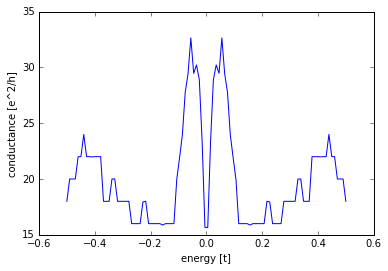

In [13]:
sys = create_sys(delta = 0.01)
energies = np.linspace(-0.5, 0.5, 100)
plot_conductance(sys, energies)

In [13]:
def get_detr(sys, energy):
    """Compute the determinant of the reflection block.

    Parameters:
    -----------
    sys : <kwant.builder.FiniteSystem> object.
        Finalized system, as returned by create_sys().

    Returns:
    --------
    detr : real.
        Determinant of the reflection block, assuming only two leads
        are attached.
    """
    smatrix = kwant.smatrix(sys, energy = energy)
    n, m = smatrix.data.shape
    rblock = np.asmatrix(smatrix.data[:n//2, :m//2])
    detr = np.linalg.det(rblock)
    return detr.real

In [14]:
def phase_diagram(murange, potentialrange):
    phase_realisations = []
    for i,potential in enumerate(potentialrange):
        phase_realisations.append([])
        for mu in murange:
            detr = get_detr(create_sys(W = 1, delta = 0.2, Vx = potential, mu = mu, mu_lead=0.07, L=50), energy = 0) 
            if  0 <= detr <= 1 :                                                 
                phase_realisations[i].append(1)
            else:
                phase_realisations[i].append(0)
    plt.ylabel("Vx")
    plt.xlabel("Mu")
    plt.title("Phase diagram of Josephson Junction", y = 1.04)
    plt.imshow(phase_realisations, extent = (murange.min(), murange.max(), potentialrange.min(), \
                                      potentialrange.max()),cmap = cm.gist_yarg) 
    #topological phase is black

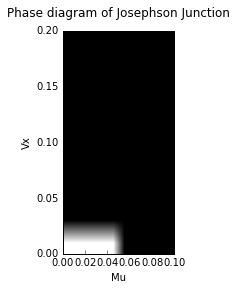

In [15]:
murange = np.linspace(0.0, 0.1,10)
potentialrange = np.linspace(0.0, 0.2, 10)
phase_diagram(murange, potentialrange)

In [16]:
def energy(delta = 1.0, mu = 1.0):  
    sys = create_sys(delta = delta, mu = mu, attach_leads = False)   
    ham_mat = sys.hamiltonian_submatrix(sparse=True) # i think solves the hamiltonian
    ev = sla.eigsh(ham_mat, k=8, which='SM', return_eigenvectors=False, maxiter=1000000) #which = what energy levels to return
                                                # SM = smallest absolute value, i.e. closest to 0, maxiter = ???, k = 8 
                                                #(number of eigenvalues we compute)
    return ev #returns eigenvalues of system closest to zero

In [17]:
#np.sort(energy(delta = 0.14, mu = 0.))

In [18]:
def make_lead(a=1, t=1.0, W=10, mu = 1.0, Vx=0.):
    # Start with an empty lead with a single square lattice
    lat = kwant.lattice.square(a)

    sym_lead = kwant.TranslationalSymmetry((-a, 0))
    lead = kwant.Builder(sym_lead)

    # build up one unit cell of the lead, and add the hoppings
    # to the next unit cell
    for j in range(W):
        lead[lat(0, j)] = on_site(a, mu, Vx)

        if j > 0:
            lead[lat(0, j), lat(0, j - 1)] = hop_vert(a)

        lead[lat(1, j), lat(0, j)] = hop_horz(a)

    return lead

In [19]:
def band_structure():
    lead = make_lead(mu = 0., W = 1, Vx=0.1).finalized()
    kwant.plotter.bands(lead, show=False)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")
    plt.show()
    #this is band structure of lead, I think I want the sys

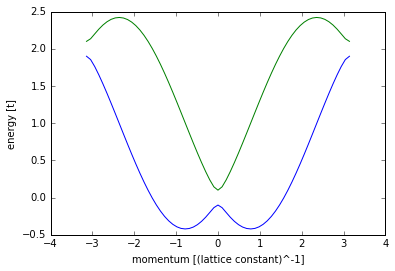

In [72]:
band_structure()

In [22]:
def evaluate_C0(murange, deltarange, potentialrange):
    list_c0   = []
    list_detr = []
    for mu in murange:
        for delta in deltarange:
            for potential in potentialrange:
                c0 = mu**2 + delta**2 - potential**2
                detr = get_detr(create_sys(W = 1, delta = delta, Vx = potential, mu = mu, mu_lead=0.3), energy = 0)
                list_c0.append(c0)
                if  0 <= detr <= 1 :
                    list_detr.append(1)
                else:
                    list_detr.append(0)
                plt    
    plt.ylabel("Topological = 1, Trivial = 0")
    plt.xlabel("C0")
    plt.title("Topological vs C0", y = 1.04)
    plt.scatter(list_c0, list_detr)
    plt.show()
    
    

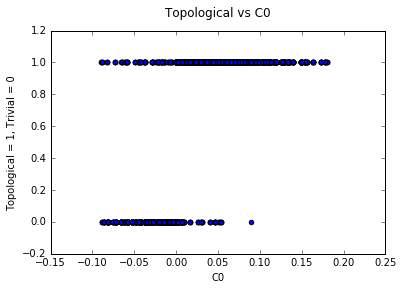

In [24]:
murange = np.linspace(-0.3, 0.3, 15)
deltarange = np.linspace(-0.3, 0.3, 15)
potentialrange = np.linspace(-0.3, 0.3, 15)
evaluate_C0(murange, deltarange, potentialrange)